In [1]:
import numpy as np
import torch, queue
from torch_geometric.data import Data
from utils import gen_edge_index
from baselines import *

/home/sam/anaconda3/envs/graphgps/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def compute_test_loss(node_embeddings, srcs, tars, lengths, mlp=None, metric='relative_loss', device='cpu'):
    srcs = srcs.to(device)
    tars = tars.to(device)
    lengths = lengths.to(device)
    if mlp == None:
        pred = torch.norm(node_embeddings[srcs] - node_embeddings[tars], p=2, dim=1)
    else:
        pred = mlp(node_embeddings[srcs], node_embeddings[tars])
    relative_losses = torch.abs(pred - lengths)/lengths
    relative_losses = relative_losses.detach().cpu().numpy()
    return np.mean(relative_losses), np.std(relative_losses), relative_losses


def npz_to_dataset(data):
    
    edge_index = torch.tensor(data['edge_index'], dtype=torch.long)

    srcs = torch.tensor(data['srcs'])
    tars = torch.tensor(data['tars'])
    lengths = torch.tensor(data['lengths'])
    node_features = torch.tensor(data['node_features'], dtype=torch.double)

    return srcs, tars, lengths, node_features, edge_index

In [38]:
import yaml
# load training yaml
with open('configs/hyperparameter-config-Transformer.yaml', 'r') as file:
    model_configs = yaml.safe_load(file)
config = model_configs['Transfomer-9']
gnn_config = config['gnn']
print(gnn_config)

{'hidden': 64, 'input': 3, 'layer_type': 'Transformer', 'layers': 2, 'output': 64}


In [4]:
# Load test data
test_path = '/data/sam/terrain/data/norway/norway-1600-test.npz'
data = np.load(test_path, allow_pickle=True)

srcs, tars, lengths, node_features, edge_index = npz_to_dataset(data)

# Load model
path = '/data/sam/terrain/models/norway-1600/baseline1/siamese/Transfomer-9/no-vn/final_model.pt'
model_info = torch.load(path, map_location='cpu')
gnn_model = GraphTransformer(**gnn_config)
#gnn_model = GNNModel(input=3, output=16, hidden=32, layers=2)
gnn_model.load_state_dict(model_info)
gnn_model = gnn_model.to(torch.double)

node_embeddings = gnn_model(node_features, edge_index)

In [5]:
mean, std, errs = compute_test_loss(node_embeddings, srcs, tars, lengths)
print(mean, std)

0.09804136868659181 0.09586651711630527


In [17]:
# Convert to networkx
from torch_geometric.utils import to_networkx
graph_pyg = Data(x=node_features, edge_index = edge_index)
G = to_networkx(graph_pyg)
for i in range(len(edge_index[0])):
    v1 = edge_index[0][i].item()
    v2 = edge_index[1][i].item()
    G[v1][v2]['weight'] = torch.norm(node_features[v1] - node_features[v2]).item()


In [20]:
import networkx as nx

nx.shortest_path_length(G, 0, 1, weight='weight')

0.5011548639144174

In [41]:
from tqdm import trange
errors = []
rand_src = np.random.choice(np.arange(len(node_features)), size=10)

for k in trange(1, 20):
    k_err = []
    for i in range(10):
        src = rand_src[i]
        k_hops = nx.single_source_shortest_path(G, src, cutoff=k)
        single_k_err = []
        for tar in k_hops:
            if tar == src:
                continue
            real_shortest_path = nx.shortest_path_length(G, src, tar, weight='weight')
            pred_shortest_path = torch.norm(node_embeddings[src] - node_embeddings[tar]).item()
            err = abs(pred_shortest_path - real_shortest_path)/real_shortest_path
            single_k_err.append(err)
        k_err.append(np.mean(single_k_err))
    errors.append(np.mean(k_err))

    

100%|██████████| 19/19 [00:21<00:00,  1.12s/it]


Text(0.5, 0, 'Number of hops away')

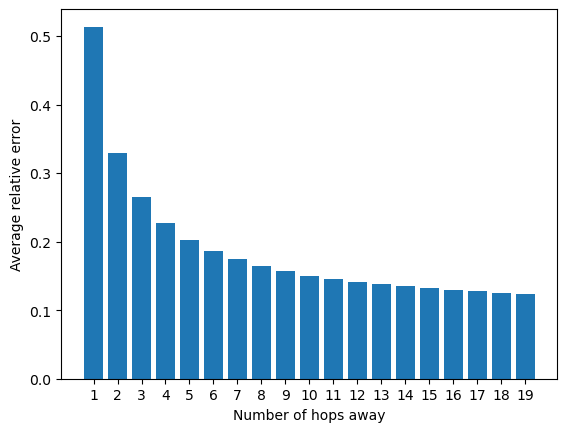

In [43]:
#path_length = data['paths']
import matplotlib.pyplot as plt
plt.bar(np.arange(1, 20), errors)
plt.xticks(np.arange(1, 20))
plt.ylabel("Average relative error")
plt.xlabel("Number of hops away")


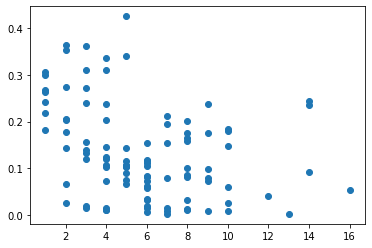

In [35]:
plt.scatter(path_length, errs)